In [123]:
import os
import random
import requests
import numpy as np
import wfdb
from scipy.stats import skew, kurtosis, ks_2samp, mannwhitneyu
from scipy.signal import find_peaks, butter, filtfilt
from sklearn.metrics import (
    mutual_info_score, accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, classification_report, silhouette_score)
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import networkx as nx
from biosppy.signals import ecg
import neurokit2 as nk
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.utils import from_networkx
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, global_mean_pool
import matplotlib.pyplot as plt
import seaborn as sns

# Downloading The Data From Physionet 

In [ ]:

def download_file(url, save_path):
    """
    Helper function to download a file from a given URL to a specified path.
    """
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, 'wb') as f:
            f.write(response.content)
    else:
        print(f"Failed to download {url}")

def sample_and_download(base_url, local_dir, groups, sample_size=500):
    """
    Samples and downloads `sample_size` .mat and corresponding .hea files from the specified groups of the dataset.
    """
    os.makedirs(local_dir, exist_ok=True)

    sampled_files = []

    for group in groups:
        group_url = os.path.join(base_url, group)

        response = requests.get(group_url)
        if response.status_code != 200:
            print(f"Failed to access {group_url}")
            continue

        all_files = [
            line.split('href="')[1].split('"')[0]
            for line in response.text.splitlines()
            if ".mat" in line
        ]

        group_sample = random.sample(all_files, min(sample_size, len(all_files)))

        # Download the sampled files (.mat and .hea)
        for file in group_sample:
            mat_url = os.path.join(group_url, file)
            hea_url = mat_url.replace('.mat', '.hea')
            
            mat_save_path = os.path.join(local_dir, f"{file}")
            hea_save_path = mat_save_path.replace('.mat', '.hea')

            download_file(mat_url, mat_save_path)  
            download_file(hea_url, hea_save_path) 

        sampled_files.extend(group_sample)

    return sampled_files

In [ ]:
datasets = {
    "chapman_shaoxing": "https://physionet.org/files/challenge-2021/1.0.3/training/chapman_shaoxing/",
    "ptb-xl": "https://physionet.org/files/challenge-2021/1.0.3/training/ptb-xl/",
    "georgia": "https://physionet.org/files/challenge-2021/1.0.3/training/georgia/"
}

local_dirs = {
    "chapman_shaoxing": "data/chapman_shaoxing",
    "ptb-xl": "data/ptb-xl",
    "georgia": "data/georgia"
}

sample_size = 2000

for dataset_name, base_url in datasets.items():
    print(f"Processing dataset: {dataset_name}")
    local_dir = local_dirs[dataset_name]
    sampled_files = sample_and_download(base_url, local_dir, groups=["g3"], sample_size=sample_size)
    print(f"Downloaded {len(sampled_files)} .mat files and corresponding .hea files for {dataset_name}")

# Preprocessing ECG Data

In [52]:

FS = 500 
TARGET_LABEL = "427084000"  

# Lead clusters for WMI weighting
LEAD_CLUSTERS = {
    "precordial": ["V1", "V2", "V3", "V4", "V5", "V6"],
    "unipolar": ["aVR", "aVL", "aVF"],
    "bipolar": ["I", "II", "III"]
}

def get_lead_cluster(lead):
    for cluster, leads in LEAD_CLUSTERS.items():
        if lead in leads:
            return cluster
    return None

def calculate_statistical_features(signal):
    mean = np.mean(signal)
    variance = np.var(signal)
    skewness = skew(signal)
    kurt = kurtosis(signal)
    return [mean, variance, skewness, kurt]



def bandpass_filter(signal, lowcut=0.5, highcut=40.0, fs=500, order=3):
    """
    Apply a bandpass filter to the signal.
    """
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)


def extract_clinical_features(signal, fs=500):
    """
    Extract QRS duration and T-wave amplitude from an ECG lead.
    
    Parameters:
        signal (numpy.ndarray): 1D array of ECG signal data.
        fs (int): Sampling frequency.
    
    Returns:
        list: Clinical features [QRS duration, T-wave amplitude].
    """
    try:
        # Clean ECG signal
        filtered_signal = bandpass_filter(signal, fs=fs)

        # Detect R-peaks using biosppy
        rpeaks_results = ecg.ecg(signal=filtered_signal, sampling_rate=fs, show=False)
        r_peaks = rpeaks_results['rpeaks']

        if len(r_peaks) < 2:
            raise ValueError("Not enough R-peaks detected for feature extraction.")

        qrs_duration = np.mean(np.diff(r_peaks)) * 1000 / fs  # QRS duration in ms

        # T-wave amplitude
        t_wave_amplitudes = []
        for r_peak in r_peaks:
            t_segment = filtered_signal[r_peak + 20:r_peak + 100]  # Look for peaks ~T-wave range
            if len(t_segment) > 0:
                t_amplitudes, _ = find_peaks(t_segment, height=np.mean(t_segment))
                if len(t_amplitudes) > 0:
                    t_wave_amplitudes.append(max(t_segment))
        t_wave_amplitude = np.mean(t_wave_amplitudes) if t_wave_amplitudes else 0.0

        return [qrs_duration, t_wave_amplitude]

    except Exception as e:
        print(f"Error extracting clinical features: {e}")
        return [0.0, 0.0]  # Default values if extraction fails.



def calculate_wmi_matrix(signals, leads):
    num_leads = signals.shape[1]
    mutual_info_matrix = np.zeros((num_leads, num_leads))
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    discretized_signals = discretizer.fit_transform(signals)

    for i in range(num_leads):
        for j in range(i + 1, num_leads):
            # Compute MI
            mutual_info = mutual_info_score(discretized_signals[:, i], discretized_signals[:, j])
            # Weighting based on lead clusters
            cluster_i = get_lead_cluster(leads[i])
            cluster_j = get_lead_cluster(leads[j])
            if cluster_i == cluster_j:
                mutual_info *= 2
            mutual_info_matrix[i, j] = mutual_info
            mutual_info_matrix[j, i] = mutual_info  # Symmetric
    return mutual_info_matrix



# Function to construct graph for a single ECG record
def construct_graph(signal, record_name, label, region, leads):
    G = nx.Graph()
    num_leads = signal.shape[1]

    # Node features: Statistical + Clinical
    for lead_idx, lead_name in enumerate(leads):
        lead_signal = signal[:, lead_idx]
        statistical_features = calculate_statistical_features(lead_signal)
        clinical_features = extract_clinical_features(lead_signal)
        
        G.add_node(
            lead_idx,
            features= statistical_features + clinical_features
        )

    wmi_matrix = calculate_wmi_matrix(signal, leads)
    for i in range(num_leads):
        for j in range(i + 1, num_leads):
            weight = wmi_matrix[i, j]
            if weight > 0:  
                G.add_edge(i, j, weight=weight)
    
    G.graph["label"] = label  # Graph-level label
    G.graph["region"] = region
    return G



def process_ecg_data(data_dir, output_dir, region):
    os.makedirs(output_dir, exist_ok=True)
    data_files = [file for file in os.listdir(data_dir) if file.endswith('.hea')]

    leads = [
        "I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"
    ]  

    for file in data_files:
        record_path = os.path.join(data_dir, file.replace('.hea', ''))
        try:
            header = wfdb.rdheader(record_path)
            signal, _ = wfdb.rdsamp(record_path)

            normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))
            
            label = 0  
            for comment in header.comments:
                if 'Dx:' in comment:
                    diagnoses = comment.split(': ')[1].split(',')
                    if TARGET_LABEL in diagnoses:
                        label = 1

            record_name = os.path.basename(record_path)
            G = construct_graph(normalized_signal, record_name, label, region, leads)

            graph_path = os.path.join(output_dir, f"{record_name}.gpickle")
            nx.write_gpickle(G, graph_path)
            print(f"Processed and saved graph for {record_name}")

        except Exception as e:
            print(f"Error processing {record_path}: {e}")

# Creating the Graphs for ECG Data

In [53]:
directories = [
    ("/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/chapman_shaoxing", "China"),
    ("/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/ptb-xl", "Germany"),
    ("/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia", "United States")
]

output_dir = "/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/output_graphs"

for data_dir, region in directories:
    process_ecg_data(data_dir, output_dir, region)


Processed and saved graph for JS01972
Processed and saved graph for JS01966
Processed and saved graph for JS00488
Processed and saved graph for JS01796
Processed and saved graph for JS01782
Processed and saved graph for JS01769
Processed and saved graph for JS00477
Processed and saved graph for JS00311
Processed and saved graph for JS00305
Processed and saved graph for JS00463
Processed and saved graph for JS01755
Processed and saved graph for JS01033
Processed and saved graph for JS00339
Processed and saved graph for JS01741
Processed and saved graph for JS01999
Processed and saved graph for JS01594
Processed and saved graph for JS00852
Processed and saved graph for JS01580
Processed and saved graph for JS00846
Processed and saved graph for JS00113
Processed and saved graph for JS00675
Processed and saved graph for JS02076
Processed and saved graph for JS00661
Processed and saved graph for JS01219
Processed and saved graph for JS00107
Processed and saved graph for JS01231
Processed an

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/chapman_shaoxing/JS00459: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for JS01753
Processed and saved graph for JS01035
Processed and saved graph for JS00303
Processed and saved graph for JS00465
Processed and saved graph for JS00471
Process

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/chapman_shaoxing/JS01040: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for JS00438
Processed and saved graph for JS01726
Processed and saved graph for JS01732
Processed and saved graph for JS01054
Processed and saved graph for JS01901
Process

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/chapman_shaoxing/JS01266: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for JS02009
Processed and saved graph for JS01500
Processed and saved graph for JS01514
Processed and saved graph for JS01272
Processed and saved graph for JS00144
Process

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00361: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for E01719
Processed and saved graph for E00407
Processed and saved graph for E00413
Processed and saved graph for E00375
Processed and saved graph for E01043
Processed and saved gr

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E01825: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for E00285
Processed and saved graph for E01824
Processed and saved graph for E00284
Processed and saved graph for E00290
Processed and saved graph for E01830
Processed and saved gr

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00282: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for E00269
Processed and saved graph for E01177
Processed and saved graph for E01611
Processed and saved graph for E01605
Processed and saved graph for E01163
Processed and saved gr

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00281: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for E01821
Processed and saved graph for E01835
Processed and saved graph for E00295
Processed and saved graph for E01160
Processed and saved graph for E01606
Processed and saved graph for E00518
Processed and saved graph for E01612
Processed and saved grap

/var/folders/n6/y7pxpz790gn3xhncjm30g6ym0000gn/T/ipykernel_41296/3133587402.py:174: RuntimeWarning: invalid value encountered in divide
  normalized_signal = (signal - np.min(signal, axis=0)) / (np.max(signal, axis=0) - np.min(signal, axis=0))


Error extracting clinical features: Not enough beats to compute heart rate.
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00145: Input X contains NaN.
KBinsDiscretizer does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values
Processed and saved graph for E00151
Processed and saved graph for E01529
Processed and saved graph for E00637
Processed and saved graph for E01501
Processed and saved graph for E00179
Processed and saved gr

In [5]:

def load_graphs(graph_dir):
    graphs = []
    for file in os.listdir(graph_dir):
        if file.endswith(".gpickle"):
            graph_path = os.path.join(graph_dir, file)
            nx_graph = nx.read_gpickle(graph_path)

            # Convert to PyTorch Geometric format
            for node in nx_graph.nodes:
                nx_graph.nodes[node]["x"] = torch.tensor(nx_graph.nodes[node]["features"], dtype=torch.float)

            pyg_graph = from_networkx(nx_graph)
            pyg_graph.label = torch.tensor([nx_graph.graph["label"]], dtype=torch.long)
            graphs.append(pyg_graph)
    return graphs


graph_dir = "/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/output_graphs"
graphs = load_graphs(graph_dir)
print(f"Loaded {len(graphs)} graphs.")


Loaded 5989 graphs.


In [14]:

train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)

train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)


# 5 GAT layers, 4 Heads

In [15]:


class GATModel_54(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super(GATModel_54, self).__init__()

        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat4 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat5 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=False)

        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gat1(x, edge_index)
        x = torch.relu(x)

        x = self.gat2(x, edge_index)
        x = torch.relu(x)

        x = self.gat3(x, edge_index)
        x = torch.relu(x)

        x = self.gat4(x, edge_index)
        x = torch.relu(x)

        x = self.gat5(x, edge_index)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

    def get_node_embeddings(self, x, edge_index):
        """
        Extract node embeddings after the final GAT layer.
        """
        with torch.no_grad():
            x = self.gat1(x, edge_index)
            x = torch.relu(x)
            x = self.gat2(x, edge_index)
            x = torch.relu(x)
            x = self.gat3(x, edge_index)
            x = torch.relu(x)
            x = self.gat4(x, edge_index)
            x = torch.relu(x)
            x = self.gat5(x, edge_index)
        return x



# 5 GAT layers, 2 Heads

In [77]:


class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=2): 
        super(GATModel, self).__init__()

        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat4 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat5 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=False)

        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gat1(x, edge_index)
        x = torch.relu(x)

        x = self.gat2(x, edge_index)
        x = torch.relu(x)

        x = self.gat3(x, edge_index)
        x = torch.relu(x)

        x = self.gat4(x, edge_index)
        x = torch.relu(x)

        x = self.gat5(x, edge_index)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

    def get_node_embeddings(self, x, edge_index):
        """
        Extract node embeddings after the final GAT layer.
        """
        with torch.no_grad():
            x = self.gat1(x, edge_index)
            x = torch.relu(x)
            x = self.gat2(x, edge_index)
            x = torch.relu(x)
            x = self.gat3(x, edge_index)
            x = torch.relu(x)
            x = self.gat4(x, edge_index)
            x = torch.relu(x)
            x = self.gat5(x, edge_index)
        return x


# 5 GAT layers, 8 Heads


In [82]:


class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=8):  # Updated to 8 heads
        super(GATModel, self).__init__()

        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat4 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat5 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=False)

        self.fc = nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.gat1(x, edge_index)
        x = torch.relu(x)

        x = self.gat2(x, edge_index)
        x = torch.relu(x)

        x = self.gat3(x, edge_index)
        x = torch.relu(x)

        x = self.gat4(x, edge_index)
        x = torch.relu(x)

        x = self.gat5(x, edge_index)

        x = global_mean_pool(x, batch)

        x = self.fc(x)
        return x

    def get_node_embeddings(self, x, edge_index):
        """
        Extract node embeddings after the final GAT layer.
        """
        with torch.no_grad():
            x = self.gat1(x, edge_index)
            x = torch.relu(x)
            x = self.gat2(x, edge_index)
            x = torch.relu(x)
            x = self.gat3(x, edge_index)
            x = torch.relu(x)
            x = self.gat4(x, edge_index)
            x = torch.relu(x)
            x = self.gat5(x, edge_index)
        return x


In [16]:

def train(model, loader, optimizer, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = cross_entropy(out, data.label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)
            correct += (pred == data.label).sum().item()
            total += data.num_graphs
    return correct / total

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel_54(in_channels=graphs[0].x.shape[1], hidden_channels=32, out_channels=2).to(device)
optimizer = Adam(model.parameters(), lr=0.001)

epochs = 300
for epoch in range(epochs):
    train_loss = train(model, train_loader, optimizer, device)
    test_acc = test(model, test_loader, device)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Epoch 1/300, Loss: 0.4045, Test Accuracy: 0.8831
Epoch 2/300, Loss: 0.2708, Test Accuracy: 0.8831
Epoch 3/300, Loss: 0.2607, Test Accuracy: 0.8831
Epoch 4/300, Loss: 0.2535, Test Accuracy: 0.9007
Epoch 5/300, Loss: 0.2451, Test Accuracy: 0.8790
Epoch 6/300, Loss: 0.2341, Test Accuracy: 0.8790
Epoch 7/300, Loss: 0.2303, Test Accuracy: 0.8790
Epoch 8/300, Loss: 0.2244, Test Accuracy: 0.9007
Epoch 9/300, Loss: 0.2207, Test Accuracy: 0.8781
Epoch 10/300, Loss: 0.2095, Test Accuracy: 0.9332
Epoch 11/300, Loss: 0.2101, Test Accuracy: 0.8840
Epoch 12/300, Loss: 0.2005, Test Accuracy: 0.8973
Epoch 13/300, Loss: 0.1990, Test Accuracy: 0.9007
Epoch 14/300, Loss: 0.1965, Test Accuracy: 0.8998
Epoch 15/300, Loss: 0.1968, Test Accuracy: 0.9257
Epoch 16/300, Loss: 0.1986, Test Accuracy: 0.9215
Epoch 17/300, Loss: 0.1964, Test Accuracy: 0.9124
Epoch 18/300, Loss: 0.1936, Test Accuracy: 0.9124
Epoch 19/300, Loss: 0.1997, Test Accuracy: 0.8957
Epoch 20/300, Loss: 0.1979, Test Accuracy: 0.8940
Epoch 21/

# Save the trained model

In [17]:
torch.save(model.state_dict(), "gat54_model.pth")

# Evaluate Accuracy (5 GAT layers, 4 Heads)

In [75]:

def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  # Get the predicted class
            correct += (pred == data.label).sum().item()
            total += data.num_graphs
    accuracy = correct / total
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_channels=graphs[0].x.shape[1], hidden_channels=32, out_channels=2, num_heads=4).to(device)
model.load_state_dict(torch.load("gat_model.pth"))
model.eval()

test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.9299



Performance Metrics:
Accuracy       : 0.9482
Precision      : 0.7294
Recall         : 0.8857
F1-Score       : 0.8000
ROC-AUC Score  : 0.9728

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1058
           1       0.73      0.89      0.80       140

    accuracy                           0.95      1198
   macro avg       0.86      0.92      0.89      1198
weighted avg       0.95      0.95      0.95      1198



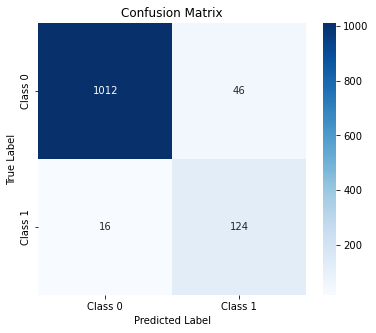

In [18]:
def evaluate_model(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  
            prob = torch.softmax(out, dim=1)[:, 1]  
            
            y_true.extend(data.label.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())
            y_scores.extend(prob.cpu().numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_scores)
    cm = confusion_matrix(y_true, y_pred)

    print("\nPerformance Metrics:")
    print(f"Accuracy       : {accuracy:.4f}")
    print(f"Precision      : {precision:.4f}")
    print(f"Recall         : {recall:.4f}")
    print(f"F1-Score       : {f1:.4f}")
    print(f"ROC-AUC Score  : {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "confusion_matrix": cm
    }

# Load the trained model parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel_54(in_channels=graphs[0].x.shape[1], hidden_channels=32, out_channels=2, num_heads=4).to(device)
model.load_state_dict(torch.load("gat54_model.pth"))
model.eval()

metrics = evaluate_model(model, test_loader, device)


# Evaluate Accuracy (5 GAT layers, 2 Heads)

In [81]:
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  # Get the predicted class
            correct += (pred == data.label).sum().item()
            total += data.num_graphs
    accuracy = correct / total
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_channels=graphs[0].x.shape[1], hidden_channels=32, out_channels=2, num_heads=2).to(device)
model.load_state_dict(torch.load("gat_model.pth"))
model.eval()

test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8831


# Evaluate Accuracy (5 GAT layers, 8 Heads)

In [85]:
def evaluate_accuracy(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            pred = out.argmax(dim=1)  # Get the predicted class
            correct += (pred == data.label).sum().item()
            total += data.num_graphs
    accuracy = correct / total
    return accuracy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GATModel(in_channels=graphs[0].x.shape[1], hidden_channels=32, out_channels=2, num_heads=8).to(device)
model.load_state_dict(torch.load("gat_model.pth"))
model.eval()

test_accuracy = evaluate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.8831


In [67]:
model = GATModel(in_channels=graphs[0].x.shape[1], hidden_channels=32, out_channels=2).to(device)
model.load_state_dict(torch.load("gat_model.pth"))
model.eval()

# Dictionary to store learned embeddings using indices as keys
learned_embeddings = {}

# Extract embeddings
with torch.no_grad():
    for idx, data in enumerate(test_loader):
        data = data.to(device)
        embeddings = model.get_node_embeddings(data.x, data.edge_index)
        learned_embeddings[f"graph_{idx}"] = embeddings.cpu().numpy()


graph_0: Shape of embeddings (384, 32)
graph_1: Shape of embeddings (384, 32)
graph_2: Shape of embeddings (384, 32)
graph_3: Shape of embeddings (384, 32)
graph_4: Shape of embeddings (384, 32)
graph_5: Shape of embeddings (384, 32)
graph_6: Shape of embeddings (384, 32)
graph_7: Shape of embeddings (384, 32)
graph_8: Shape of embeddings (384, 32)
graph_9: Shape of embeddings (384, 32)
graph_10: Shape of embeddings (384, 32)
graph_11: Shape of embeddings (384, 32)
graph_12: Shape of embeddings (384, 32)
graph_13: Shape of embeddings (384, 32)
graph_14: Shape of embeddings (384, 32)
graph_15: Shape of embeddings (384, 32)
graph_16: Shape of embeddings (384, 32)
graph_17: Shape of embeddings (384, 32)
graph_18: Shape of embeddings (384, 32)
graph_19: Shape of embeddings (384, 32)
graph_20: Shape of embeddings (384, 32)
graph_21: Shape of embeddings (384, 32)
graph_22: Shape of embeddings (384, 32)
graph_23: Shape of embeddings (384, 32)
graph_24: Shape of embeddings (384, 32)
graph_25: 

In [69]:

region_embeddings = {"China": [], "Germany": [], "United States": []}


for idx, data in enumerate(test_loader):
    data = data.to(device)
    embeddings = model.get_node_embeddings(data.x, data.edge_index)
    
    region = data.region[0] if isinstance(data.region, list) else data.region
    
    if region in region_embeddings:
        region_embeddings[region].append(embeddings.cpu().detach().numpy())
    else:
        print(f"Warning: Unknown region {region} encountered.")

for region in region_embeddings:
    if len(region_embeddings[region]) > 0:  # Ensure there are embeddings to stack
        region_embeddings[region] = np.vstack(region_embeddings[region])


Region: China, Shape: (6144, 32)
Region: Germany, Shape: (3456, 32)
Region: United States, Shape: (4776, 32)


In [70]:

# Function to compare embeddings using K-S test
def compare_regions_with_ks(region_embeddings):
    regions = list(region_embeddings.keys())
    for i in range(len(regions)):
        for j in range(i + 1, len(regions)):
            region1, region2 = regions[i], regions[j]
            
            # Flatten embeddings for statistical comparison
            emb1 = region_embeddings[region1].flatten()
            emb2 = region_embeddings[region2].flatten()
            
            # Apply K-S test
            ks_stat, p_value = ks_2samp(emb1, emb2)
            print(f"K-S Test between {region1} and {region2}:")
            print(f"  KS Statistic: {ks_stat:.4f}, P-value: {p_value:.4e}")
            if p_value < 0.05:
                print("  -> Statistically significant difference.\n")
            else:
                print("  -> No significant difference.\n")

compare_regions_with_ks(region_embeddings)


K-S Test between China and Germany:
  KS Statistic: 0.0120, P-value: 2.4495e-09
  -> Statistically significant difference.

K-S Test between China and United States:
  KS Statistic: 0.0063, P-value: 2.1141e-03
  -> Statistically significant difference.

K-S Test between Germany and United States:
  KS Statistic: 0.0076, P-value: 1.1420e-03
  -> Statistically significant difference.



In [1]:

FS = 500  
TARGET_LABEL = "427084000"

def load_raw_ecg_data(data_dir, num_samples=5000):
    """
    Load raw ECG signals from Physionet files.

    Parameters:
        data_dir (str): Path to the directory containing .hea and signal files.
        num_samples (int): Number of samples to use for each lead.

    Returns:
        Tuple of numpy arrays (all_data, all_labels)
    """
    all_data = []
    all_labels = []
    leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    for file in os.listdir(data_dir):
        if file.endswith(".hea"):
            record_path = os.path.join(data_dir, file.replace('.hea', ''))
            try:
                # Read header and signal
                header = wfdb.rdheader(record_path)
                signal, _ = wfdb.rdsamp(record_path, sampfrom=0, sampto=num_samples)  # Fixed number of samples

                # Check for target label
                label = 0
                for comment in header.comments:
                    if 'Dx:' in comment:
                        diagnoses = comment.split(': ')[1].split(',')
                        if TARGET_LABEL in diagnoses:
                            label = 1

                # Flatten ECG signal (12 leads)
                flattened_signal = signal.T.flatten()  # Transpose to shape (12 leads, N samples), then flatten
                all_data.append(flattened_signal)
                all_labels.append(label)
            except Exception as e:
                print(f"Error processing {record_path}: {e}")
    
    return np.array(all_data), np.array(all_labels)

# Directories for Different Regions
directories = [
    ("/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/chapman_shaoxing", "China"),
    ("/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/ptb-xl", "Germany"),
    ("/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia", "United States")
]

# Combine Data from All Regions
all_data = []
all_labels = []

for data_dir, region in directories:
    print(f"Processing data from {region}")
    data, labels = load_raw_ecg_data(data_dir)
    all_data.append(data)
    all_labels.append(labels)

X = np.vstack(all_data)
y = np.concatenate(all_labels)

print(f"Total Samples: {X.shape[0]}, Input Shape: {X.shape[1]}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
print("\nTraining Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

def evaluate_model(y_true, y_pred, y_prob, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)
    f1 = f1_score(y_true, y_pred)
    print(f"{model_name} - Accuracy: {accuracy:.4f}, ROC-AUC: {roc_auc:.4f}, F1-Score: {f1:.4f}")

print("\nEvaluation Results:")
evaluate_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")
evaluate_model(y_test, y_pred_svm, y_prob_svm, "SVM")


/Users/ranykhirbawi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/ranykhirbawi/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


hey
Processing data from China
Processing data from Germany
Processing data from United States
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00947: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00996: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00968: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00843: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00857: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00841: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/georgia/E00911: sampto must be shorter than the signal length
Error processing /Users/ranykhirbawi/

NameError: name 'y_pred_svm' is not defined

In [74]:

graph_dir = "/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/output_graphs"

def load_region_graphs(graph_dir):
    """
    Load graphs from the directory and classify them based on the 'region' attribute.
    Args:
        graph_dir (str): Path to the directory containing .gpickle graph files.
    Returns:
        dict: A dictionary with keys as region names and values as lists of graphs.
    """
    region_graphs = {"Germany": [], "China": [], "United States": []}

    for file in os.listdir(graph_dir):
        if file.endswith(".gpickle"):
            graph_path = os.path.join(graph_dir, file)
            nx_graph = nx.read_gpickle(graph_path)

            region = nx_graph.graph.get("region")
            if region not in region_graphs:
                print(f"Warning: Skipping graph {file} due to missing or unknown region.")
                continue

            for node in nx_graph.nodes:
                nx_graph.nodes[node]["x"] = torch.tensor(nx_graph.nodes[node]["features"], dtype=torch.float)

            # Convert to PyTorch Geometric format
            pyg_graph = from_networkx(nx_graph)

            if "label" in nx_graph.graph:
                pyg_graph.label = torch.tensor([nx_graph.graph["label"]], dtype=torch.long)
            else:
                pyg_graph.label = torch.tensor([0], dtype=torch.long)  # Default label

            region_graphs[region].append(pyg_graph)

    return region_graphs


graph_dir = "/Users/ranykhirbawi/Desktop/DATA_MED_PROJECT/output_graphs"

region_graphs = load_region_graphs(graph_dir)

china_graphs = region_graphs["China"]
germany_graphs = region_graphs["Germany"]
us_graphs = region_graphs["United States"]

print(f"Loaded {len(china_graphs)} graphs for China region.")
print(f"Loaded {len(germany_graphs)} graphs for Germany region.")
print(f"Loaded {len(us_graphs)} graphs for United States region.")
from torch_geometric.nn import GATConv, global_mean_pool
import torch.nn as nn

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads)
        self.fc = nn.Linear(hidden_channels * num_heads, out_channels)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = torch.relu(self.gat1(x, edge_index))
        x = torch.relu(self.gat2(x, edge_index))
        x = global_mean_pool(x, batch)
        return self.fc(x)

def train_model(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader, device):
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.label.cpu().numpy()
            
            all_preds.extend(preds)
            all_labels.extend(labels)
    
    accuracy = accuracy_score(all_labels, all_preds)

    
    return accuracy





Loaded 1996 graphs for China region.
Loaded 1999 graphs for Germany region.
Loaded 1994 graphs for United States region.


In [65]:
model = GATModel(in_channels=china_graphs[0].x.shape[1], hidden_channels=32, out_channels=2, num_heads=4)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()



# Split dataset into train and test
train_graphs_germany, test_graphs_germany = train_test_split(germany_graphs, test_size=0.2, random_state=42)
train_graphs_us, test_graphs_us = train_test_split(us_graphs, test_size=0.2, random_state=42)
train_graphs_china, test_graphs_china = train_test_split(china_graphs, test_size=0.2, random_state=42)

# Create DataLoaders
test_loader_germany = DataLoader(test_graphs_germany, batch_size=16, shuffle=False)




# Train on one region (Germany)
train_loader_germany = DataLoader(train_graphs_germany, batch_size=16, shuffle=True)
for epoch in range(15):  # Adjust epochs as needed
    loss = train_model(model, train_loader_germany, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}, Loss: {loss:.4f}")

# Test on another region (China)
china_loader = DataLoader(test_graphs_china, batch_size=16, shuffle=False)

# Evaluate on China
acc = evaluate_model(model, china_loader, device)
print(f"[Trained: Germany] => Test on China:\n"
      f"  Accuracy:  {acc:.4f}\n"
     )
# Test on another region (US)
us_loader = DataLoader(test_graphs_us, batch_size=16, shuffle=False)
# Evaluate on US
acc = evaluate_model(model, us_loader, device)
print(f"[Trained: Germany] => Test on US:\n"
      f"  Accuracy:  {acc:.4f}\n"
     )

# Test on another region (US)
germany_loader = DataLoader(test_graphs_germany, batch_size=16, shuffle=False)

# Evaluate on Germany itself
acc = evaluate_model(model, test_loader_germany, device)
print(f"[Trained: Germany] => Test on Germany:\n"
      f"  Accuracy:  {acc:.4f}\n"
     )

/Users/ranykhirbawi/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 1, Loss: 11.2382
Epoch 2, Loss: 1.8630
Epoch 3, Loss: 0.1857
Epoch 4, Loss: 0.1456
Epoch 5, Loss: 0.1274
Epoch 6, Loss: 0.1514
Epoch 7, Loss: 0.1432
Epoch 8, Loss: 0.1379
Epoch 9, Loss: 0.1176
Epoch 10, Loss: 0.1047
Epoch 11, Loss: 0.1252
Epoch 12, Loss: 0.1032
Epoch 13, Loss: 0.0961
Epoch 14, Loss: 0.1078
Epoch 15, Loss: 0.1055
[Trained: Germany] => Test on China:
  Accuracy:  0.8125

[Trained: Germany] => Test on US:
  Accuracy:  0.8672

[Trained: Germany] => Test on Germany:
  Accuracy:  0.9625



/Users/ranykhirbawi/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/Users/ranykhirbawi/opt/anaconda3/lib/python3.9/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [101]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    region_to_index = {"China": 0, "Germany": 1, "United States": 2}
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        target = torch.tensor([region_to_index[region] for region in data.region], dtype=torch.long).to(device)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    region_to_index = {"China": 0, "Germany": 1, "United States": 2}

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            target = torch.tensor([region_to_index[region] for region in data.region], dtype=torch.long).to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = target.cpu().numpy()

            
            all_preds.extend(preds)
            all_labels.extend(labels)
    return accuracy_score(all_labels, all_preds)

class GATModel(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super(GATModel, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.fc = nn.Linear(hidden_channels * num_heads, out_channels)

    def forward(self, data, return_embeddings=False):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))
        x = global_mean_pool(x, data.batch)
        if return_embeddings:
            return x  # Return embeddings
        return self.fc(x)



regions = ["China","Germany","United States"]

# Train and evaluate per region
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 50
hidden_channels = 32
out_channels = len(regions)


results = {}
for region in regions:
    train_graphs, test_graphs = train_test_split(region_graphs[region], test_size=0.2, random_state=42)
    train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

    model = GATModel(in_channels=china_graphs[0].x.shape[1], hidden_channels=hidden_channels, out_channels=out_channels).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Train model
    for epoch in range(num_epochs):
        loss = train_model(model, train_loader, optimizer, criterion, device)
        print(f"Region: {region}, Epoch: {epoch+1}, Loss: {loss:.4f}")

    # Evaluate model
    acc = evaluate_model(model, test_loader, device)
    results[region] = acc
    print(f"Region: {region}, Test Accuracy: {acc:.4f}")

print("Final Results:", results)


Region: China, Epoch: 1, Loss: 0.0481
Region: China, Epoch: 2, Loss: 0.0000
Region: China, Epoch: 3, Loss: 0.0000
Region: China, Epoch: 4, Loss: 0.0000
Region: China, Epoch: 5, Loss: 0.0000
Region: China, Epoch: 6, Loss: 0.0000
Region: China, Epoch: 7, Loss: 0.0000
Region: China, Epoch: 8, Loss: 0.0000
Region: China, Epoch: 9, Loss: 0.0000
Region: China, Epoch: 10, Loss: 0.0000
Region: China, Epoch: 11, Loss: 0.0000
Region: China, Epoch: 12, Loss: 0.0000
Region: China, Epoch: 13, Loss: 0.0000
Region: China, Epoch: 14, Loss: 0.0000
Region: China, Epoch: 15, Loss: 0.0000
Region: China, Epoch: 16, Loss: 0.0000
Region: China, Epoch: 17, Loss: 0.0000
Region: China, Epoch: 18, Loss: 0.0000
Region: China, Epoch: 19, Loss: 0.0000
Region: China, Epoch: 20, Loss: 0.0000
Region: China, Epoch: 21, Loss: 0.0000
Region: China, Epoch: 22, Loss: 0.0000
Region: China, Epoch: 23, Loss: 0.0000
Region: China, Epoch: 24, Loss: 0.0000
Region: China, Epoch: 25, Loss: 0.0000
Region: China, Epoch: 26, Loss: 0.

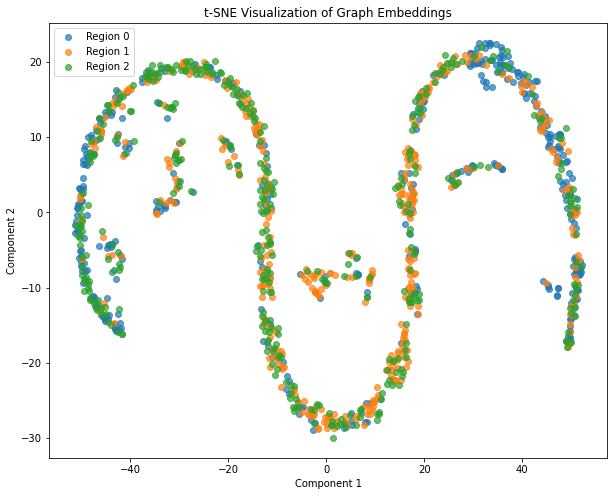

In [102]:
def extract_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []
    region_to_index = {"China": 0, "Germany": 1, "United States": 2}

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            emb = model(data, return_embeddings=True)
            embeddings.append(emb.cpu().numpy())
            target = torch.tensor([region_to_index[region] for region in data.region], dtype=torch.long).to(device)
            labels.extend(target.cpu().numpy())
    return np.concatenate(embeddings), np.array(labels)

all_embeddings = []
all_labels = []
for region, loader in [("Germany", test_loader_germany), ("China", china_loader), ("UnitedStates", us_loader)]:
    embeddings, labels = extract_embeddings(model, loader, device)
    all_embeddings.append(embeddings)
    all_labels.append(labels)

# Combine embeddings and labels
embeddings = np.concatenate(all_embeddings)
labels = np.concatenate(all_labels)

# Visualize with t-SNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

plt.figure(figsize=(10, 8))
for label in np.unique(labels):
    idx = labels == label
    plt.scatter(reduced_embeddings[idx, 0], reduced_embeddings[idx, 1], label=f"Region {label}", alpha=0.7)
plt.legend()
plt.title("t-SNE Visualization of Graph Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


In [103]:
all_labels = np.concatenate([np.array(labels) for labels in all_labels])


silhouette = silhouette_score(reduced_embeddings, all_labels)
print(f"Silhouette Score: {silhouette:.4f}")


Silhouette Score: -0.0355


In [104]:

class GATModel_Region54(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4):
        super(GATModel_Region54, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat4 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.gat5 = GATConv(hidden_channels * num_heads, hidden_channels, heads=num_heads, concat=True)
        self.fc = nn.Linear(hidden_channels * num_heads, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.gat1(x, edge_index))
        x = F.relu(self.gat2(x, edge_index))
        x = F.relu(self.gat3(x, edge_index))
        x = F.relu(self.gat4(x, edge_index))
        x = F.relu(self.gat5(x, edge_index))
        x = global_mean_pool(x, data.batch)
        return self.fc(x)

def train_model(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.label)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.label.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return accuracy_score(all_labels, all_preds)

regions = ["Germany", "China", "United States"]


cross_results = {}
for train_region in regions:
    for test_region in regions:
        if train_region == test_region:
            continue

        train_graphs = region_graphs[train_region]
        test_graphs = region_graphs[test_region]
        train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
        test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

        model = GATModel_Region54(in_channels=china_graphs[0].x.shape[1], hidden_channels=32, out_channels=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(50):
            train_model(model, train_loader, optimizer, criterion, device)

        # Evaluate on test region
        acc = evaluate_model(model, test_loader, device)
        cross_results[(train_region, test_region)] = acc
        print(f"Trained on {train_region}, Tested on {test_region}: Accuracy = {acc:.4f}")
        

print("Cross-Region Results:")
for (train_region, test_region), acc in cross_results.items():
    print(f"Trained on {train_region}, Tested on {test_region}: Accuracy = {acc:.4f}")


Trained on Germany, Tested on China: Accuracy = 0.8497
Trained on Germany, Tested on United States: Accuracy = 0.8365
Trained on China, Tested on Germany: Accuracy = 0.9715
Trained on China, Tested on United States: Accuracy = 0.7693
Trained on United States, Tested on Germany: Accuracy = 0.9105
Trained on United States, Tested on China: Accuracy = 0.9048
Cross-Region Results:
Trained on Germany, Tested on China: Accuracy = 0.8497
Trained on Germany, Tested on United States: Accuracy = 0.8365
Trained on China, Tested on Germany: Accuracy = 0.9715
Trained on China, Tested on United States: Accuracy = 0.7693
Trained on United States, Tested on Germany: Accuracy = 0.9105
Trained on United States, Tested on China: Accuracy = 0.9048


In [113]:
# Store cross-region results in a matrix for visualization
result_matrix = np.zeros((len(regions), len(regions)))
region_to_idx = {region: idx for idx, region in enumerate(regions)}

for region in regions:
    # Prepare data loaders
    graphs = region_graphs[region]
    train_graphs, test_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
    train_loader = DataLoader(train_graphs, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_graphs, batch_size=16, shuffle=False)

    # Initialize model
    model = GATModel_Region54(in_channels=china_graphs[0].x.shape[1], hidden_channels=32, out_channels=2).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Train model
    for epoch in range(50):
        train_model(model, train_loader, optimizer, criterion, device)

    # Evaluate on same-region test set
    acc = evaluate_model(model, test_loader, device)
    result_matrix[region_to_idx[region], region_to_idx[region]] = acc
    print(f"Trained and Tested on {region}: Accuracy = {acc:.4f}")



Trained and Tested on Germany: Accuracy = 0.9750
Trained and Tested on China: Accuracy = 0.8575
Trained and Tested on United States: Accuracy = 0.9424


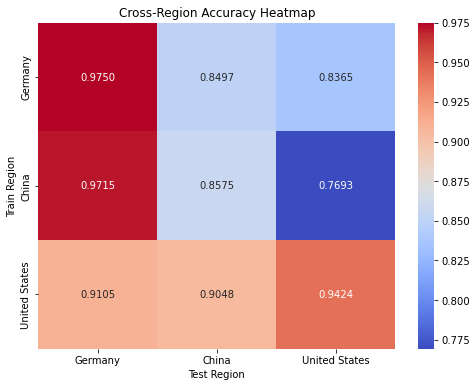

Performance Summary:
Trained on Germany, Tested on China: Accuracy = 0.8497
Trained on Germany, Tested on United States: Accuracy = 0.8365
Trained on China, Tested on Germany: Accuracy = 0.9715
Trained on China, Tested on United States: Accuracy = 0.7693
Trained on United States, Tested on Germany: Accuracy = 0.9105
Trained on United States, Tested on China: Accuracy = 0.9048

Most Challenging Train-Test Pairs:
Trained on China, Tested on United States: Accuracy = 0.7693
Trained on Germany, Tested on United States: Accuracy = 0.8365
Trained on Germany, Tested on China: Accuracy = 0.8497


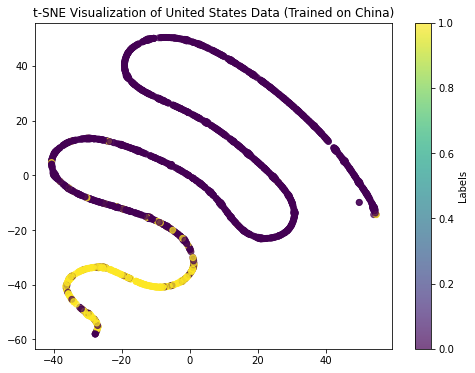

In [114]:
def get_embeddings(model, loader, device):
    model.eval()
    embeddings = []
    labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            x, edge_index = data.x, data.edge_index
            x = F.relu(model.gat1(x, edge_index))
            x = F.relu(model.gat2(x, edge_index))
            x = F.relu(model.gat3(x, edge_index))
            x = F.relu(model.gat4(x, edge_index))
            x = F.relu(model.gat5(x, edge_index))
            x = global_mean_pool(x, data.batch)
            embeddings.append(x.cpu().numpy())
            labels.extend(data.label.cpu().numpy())
    return np.vstack(embeddings), np.array(labels)





for (train_region, test_region), acc in cross_results.items():
    train_idx = region_to_idx[train_region]
    test_idx = region_to_idx[test_region]
    result_matrix[train_idx, test_idx] = acc

plt.figure(figsize=(8, 6))
sns.heatmap(result_matrix, annot=True, xticklabels=regions, yticklabels=regions, cmap="coolwarm", fmt=".4f")
plt.title("Cross-Region Accuracy Heatmap")
plt.xlabel("Test Region")
plt.ylabel("Train Region")
plt.show()

print("Performance Summary:")
for (train_region, test_region), acc in cross_results.items():
    print(f"Trained on {train_region}, Tested on {test_region}: Accuracy = {acc:.4f}")

# Visualize most challenging cases
challenging_pairs = sorted(cross_results.items(), key=lambda x: x[1])[:3]
print("\nMost Challenging Train-Test Pairs:")
for (train_region, test_region), acc in challenging_pairs:
    print(f"Trained on {train_region}, Tested on {test_region}: Accuracy = {acc:.4f}")

challenging_case = challenging_pairs[0]  # Select the most challenging pair
train_region, test_region = challenging_case[0]

train_loader = DataLoader(region_graphs[train_region], batch_size=16, shuffle=True)
test_loader = DataLoader(region_graphs[test_region], batch_size=16, shuffle=False)

# Extract embeddings
embeddings, labels = get_embeddings(model, test_loader, device)

# t-SNE visualization for challenging case
reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embeddings)
plt.figure(figsize=(8, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap="viridis", alpha=0.7)
plt.colorbar(label="Labels")
plt.title(f"t-SNE Visualization of {test_region} Data (Trained on {train_region})")
plt.show()


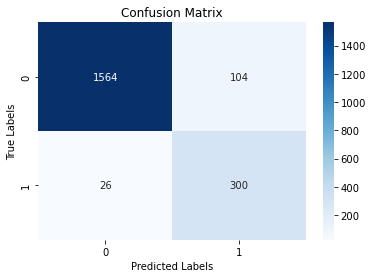

In [118]:
def evaluate_model_with_predictions(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            preds = out.argmax(dim=1).cpu().numpy()
            labels = data.label.cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels)
    return np.array(all_labels), np.array(all_preds)

true_labels, predicted_labels = evaluate_model_with_predictions(model, test_loader, device)

residuals = np.abs(true_labels - predicted_labels)


cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [119]:
region_weights = {
    "Germany": 1.0,
    "China": 1.2,
    "United States": 0.8
}

def train_model_with_region_weights(model, loader, optimizer, criterion, region, device):
    model.train()
    total_loss = 0
    weight = region_weights.get(region, 1.0)  # Default weight = 1.0
    for data in loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.label) * weight  # Apply region weight
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


In [120]:

def validate_region_influence(embeddings_by_region):
    regions = list(embeddings_by_region.keys())
    print("Statistical Tests on Embedding Distributions:")
    for i, region1 in enumerate(regions):
        for j, region2 in enumerate(regions):
            if i >= j:
                continue
            # Perform tests on embeddings
            dist1 = embeddings_by_region[region1]
            dist2 = embeddings_by_region[region2]
            ks_stat, ks_p = ks_2samp(dist1.flatten(), dist2.flatten())
            u_stat, u_p = mannwhitneyu(dist1.flatten(), dist2.flatten())
            print(f"{region1} vs {region2}:")
            print(f"  KS Test: stat={ks_stat:.4f}, p={ks_p:.4f}")
            print(f"  Mann-Whitney U Test: stat={u_stat:.4f}, p={u_p:.4f}")


Statistical Tests on Embedding Distributions:
Germany vs China:
  KS Test: stat=0.0162, p=0.0000
  Mann-Whitney U Test: stat=32846395330.0000, p=0.0000
Germany vs United States:
  KS Test: stat=0.0165, p=0.0000
  Mann-Whitney U Test: stat=32811009699.5000, p=0.0000
China vs United States:
  KS Test: stat=0.0192, p=0.0000
  Mann-Whitney U Test: stat=32583392861.0000, p=0.4423


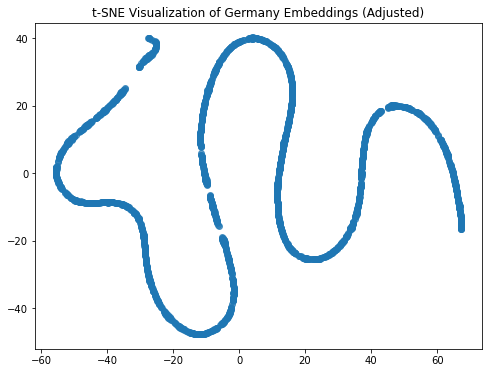

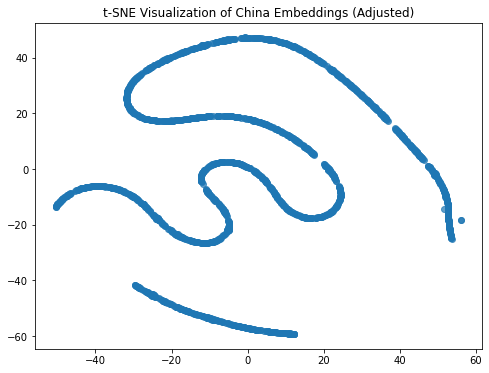

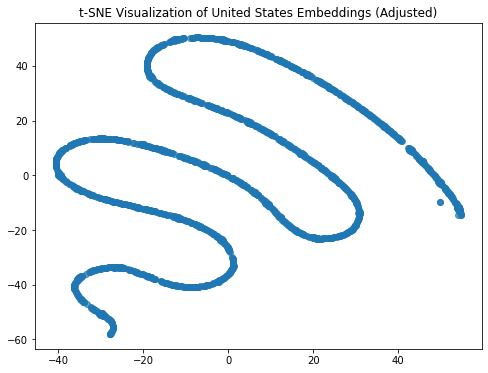

In [121]:
embeddings_by_region = {}
for region in regions:
    test_loader = DataLoader(region_graphs[region], batch_size=16, shuffle=False)
    embeddings, _ = get_embeddings(model, test_loader, device)
    embeddings_by_region[region] = embeddings

# Validate region influence
validate_region_influence(embeddings_by_region)

# Visualize t-SNE for adjusted embeddings
for region in regions:
    reduced_embeddings = TSNE(n_components=2, random_state=42).fit_transform(embeddings_by_region[region])
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.7)
    plt.title(f"t-SNE Visualization of {region} Embeddings (Adjusted)")
    plt.show()

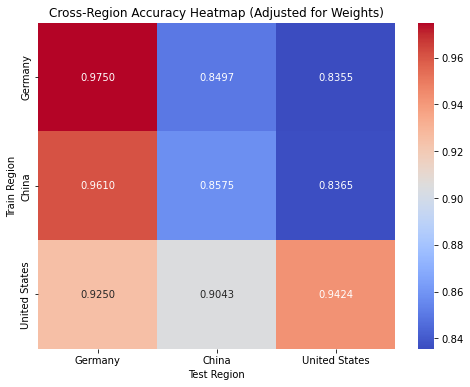

In [122]:
for train_region in regions:
    for test_region in regions:
        if train_region == test_region:
            continue
        # Train model with region-specific weights
        train_loader = DataLoader(region_graphs[train_region], batch_size=16, shuffle=True)
        test_loader = DataLoader(region_graphs[test_region], batch_size=16, shuffle=False)
        model = GATModel_Region54(in_channels=china_graphs[0].x.shape[1], hidden_channels=32, out_channels=2).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(50):
            train_model_with_region_weights(model, train_loader, optimizer, criterion, train_region, device)
        
        acc = evaluate_model(model, test_loader, device)
        cross_results[(train_region, test_region)] = acc

# Plot updated heatmap
for (train_region, test_region), acc in cross_results.items():
    train_idx = region_to_idx[train_region]
    test_idx = region_to_idx[test_region]
    result_matrix[train_idx, test_idx] = acc

plt.figure(figsize=(8, 6))
sns.heatmap(result_matrix, annot=True, xticklabels=regions, yticklabels=regions, cmap="coolwarm", fmt=".4f")
plt.title("Cross-Region Accuracy Heatmap (Adjusted for Weights)")
plt.xlabel("Test Region")
plt.ylabel("Train Region")
plt.show()

In [56]:
%history


import os
import wfdb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
print("hey")
# Constants
FS = 500  # Sampling frequency
TARGET_LABEL = "427084000"

# Function to Load Raw ECG Data
def load_raw_ecg_data(data_dir, num_samples=5000):
    """
    Load raw ECG signals from Physionet files.

    Parameters:
        data_dir (str): Path to the directory containing .hea and signal files.
        num_samples (int): Number of samples to use for each lead.

    Returns:
        Tuple of numpy arrays (all_data, all_labels)
    """
    all_data = []
    all_labels = []
    leads = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

    for file in os.listdir(data_dir):
        if file.endswith(".hea"):
            record_path = os.path.join(data_dir, file.replace('.hea', ''))
            try:
      